# Test fitting

Ensures that the WrappedMCMC class works correctly when fitting simulated data with a batman model

In [1]:
import batman
import matplotlib.pyplot as plt
import numpy as np
from erebus.mcmc_model import WrappedMCMC
from erebus.utility.bayesian_parameter import Parameter
from matplotlib.ticker import MaxNLocator

In [2]:
params = None
transit_model = None
def physical_model(x, t_sec, fp, rp_rstar, a_rstar, b, per):	
	# Convert impact to inclination
	inc = np.rad2deg(np.arccos(b / a_rstar))

	global params
	global transit_model
	if params is None:
		params = batman.TransitParams()
		params.t0 = 0
		params.t_secondary = t_sec
		params.fp = fp * 1e-6
		params.rp = rp_rstar
		params.inc = inc
		params.per = per
		params.a = a_rstar  
		params.ecc = 0.0  # Fixed: circular orbit
		params.w = 90.0  # Fixed: circular orbit
		params.limb_dark = "quadratic"
		params.u = [0.3, 0.3]
		transit_model = batman.TransitModel(params, x, transittype="secondary")
	params.t_secondary = t_sec
	params.fp = fp * 1e-6
	flux_model = transit_model.light_curve(params)
	return (flux_model - params.fp) * 1e6 # ppm

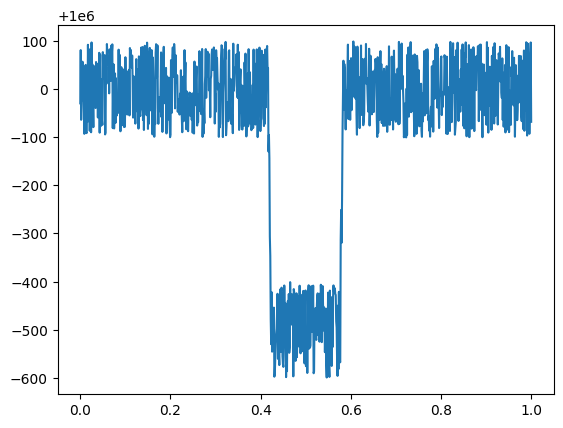

In [3]:
initial_values = [0.5, 500, 0.05, 10, 0, 5]
time = np.linspace(0, 1, 1000)
flux = physical_model(time, *initial_values) + (((2 * np.random.rand(len(time))) - 1) * 100)

plt.plot(time, flux)
plt.show()

## Using the MCMC

In [5]:
mcmc = WrappedMCMC()
mcmc.add_parameter("t_sec", Parameter.uniform_prior(0.5, 0.3, 0.7))
mcmc.add_parameter("fp", Parameter.uniform_prior(0, -2000, 2000))
mcmc.add_parameter("rp_rstar", Parameter.fixed(0.05))
mcmc.add_parameter("a_rstar", Parameter.fixed(10))
mcmc.add_parameter("b", Parameter.fixed(0))
mcmc.add_parameter("per", Parameter.fixed(5))
mcmc.add_parameter("y_err", Parameter.fixed(100))
mcmc.set_method(physical_model)

print("Testing no cache")
#mcmc.run(time, flux)
print("\n\nTesting save to cache")
mcmc.run(time, flux, cache_file = "./test_output/test_mcmc.h5", force_clear_cache = True)
print("\n\nTesting continuing from cache")
mcmc.run(time, flux, cache_file = "./test_output/test_mcmc.h5")

Testing no cache


Testing save to cache
No currently saved data
Initial guesses: [0.5, 0.0] variation: [0.04999999999999999, 500.0]
Initial likelihood: -7603.421971509668
Fitting for 2 parameters


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.80it/s]


Moved away from starting positions for chain #Moved away from starting positions for chain #  01

Initial guesses shape: (2, 64, 2)
Mean likelihood at start: -5693.941927343235
Processing chain #0
Processing chain #1


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.57it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.62406674 24.95822281]
Rubin gelman convergence: [0.99999193 0.99999193] converged? True
Autocorr time: inf converged? False
Iterations: 0 Max steps: 200000
Continue looping? True
Processing chain #0
Processing chain #1


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.88it/s]


Rubin gelman convergence: [0.99999603 0.99999603] converged? True
Autocorr time: 27.965393100256236 converged? True
Iterations: 1000 Max steps: 200000
Continue looping? False
Autocorr time: 27.965393100256236


Testing continuing from cache
Processing chain #0
Processing chain #1


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:14<00:00, 13.50it/s]


Rubin gelman convergence: [0.99999737 0.99999737] converged? True
Autocorr time: 29.498913888417597 converged? True
Iterations: 2000 Max steps: 200000
Continue looping? False
Autocorr time: 29.498913888417597


In [6]:
print(mcmc.results)

{'t_sec': 0.4997995647607547+/-0.0003581666386303639, 'fp': 493.2499103647026+/-8.021649703125291, 'rp_rstar': 0.05+/-0, 'a_rstar': 10.0+/-0, 'b': 0.0+/-0, 'per': 5.0+/-0, 'y_err': 100.0+/-0}


In [7]:
values = [mcmc.results[key].nominal_value for key in mcmc.results]
print(values)

[0.4997995647607547, 493.2499103647026, 0.05, 10.0, 0.0, 5.0, 100.0]


In [8]:
free_param_values = [mcmc.results[key].nominal_value for key in mcmc.get_free_params()]

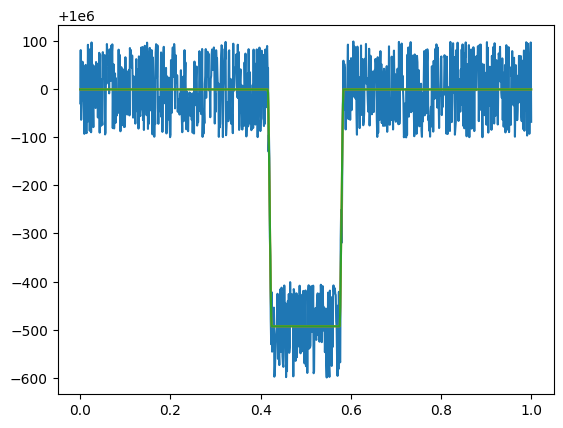

In [9]:
plt.plot(time, flux)
plt.plot(time, mcmc.evaluate_model(time, *free_param_values))
plt.plot(time, physical_model(time, *values[:-1]))
plt.show()

In [10]:
import erebus.plotting as plotting

plotting.corner_plot(mcmc)
plotting.chain_plot(mcmc)